# Visualizing Convolutional Neural Networks

*Code samples adapted from Francois Chollet:*
https://github.com/fchollet/deep-learning-with-python-notebooks/

Before we get into the content, here's an example of the Freeze plugin for Jupyter:
First, a normal cell that we can read, write, and execute. This is the default setting for a code cell. To set a cell to this setting, click the open lock icon in the toolbar at the top of the notebook.

In [2]:
print("This is a normal Jupyter cell")

This is a normal Jupyter cell


Next, a read-only cell which we can execute, but whose content we cannot change. Note that we can re-execute the cell and get different output, but we can't change the content of the code. To set a cell to this setting, click the closed lock icon in the toolbar at the top of the notebook.

In [3]:
import numpy as np
print(np.random.rand(3))

[ 0.00952563  0.55388918  0.01317181]


Finally, a cell which cannot be changed or executed. It is "frozen." Notice that attempting to re-run this cell will not change the output of the cell. To set a cell to this setting, click the asterisk icon in the toolbar at the top of the notebook. Noti

In [41]:
print("JavaScript is a terrible programming language.")
print(np.random.rand(3))

JavaScript is a terrible programming language.
[ 0.94994741  0.32457316  0.2626318 ]


an important note about Freeze... it seems like if you copy/paste cells, it can cause weird issues with Freeze where the pasted cell is guaranteed to share the lock/unlock/freeze status of the original copied cell. Modifying the state of either cell will modify both of them. It's very odd.

## Now on to CNN Visualization...

Deep learning models are frequently treated with a "black-box" mentality: users simply care about output and don't care to take a look inside to see what's going on. Since convolutional neural networks are, abstractly speaking, "representations of visual concepts" (Chollet), they are viable for visualization.

There are numerous ways to visualize the underlying structure and state of a CNN. Chollet explores 3 particularly useful and intuitive techniques for visualizing convolutional networks:
* Visualizing intermediate outputs / activations
* Visualizing convolutional filters
* Visualizing heatmaps of class activations in input images (for classification CNNs only)

### Visualizing Intermediate Activations

Given an arbitrary input to a CNN, we can visualize the activation of each layer of the network by displaying the feature maps that are output by each layer of the network. For each layer, there is a 3-dimensional feature map which can be visualized as a set of 2D images, one for each channel. The resulting images are representations of the filter activations of individual channels in a convolutional or pooling layer. Chollet uses the following example of a cat image to visualize the contents of a CNN used to descriminate between cats and dogs.

The following visualization code is adapted from Chollet's Jupyter Notebooks for his book:
 https://github.com/fchollet/deep-learning-with-python-notebooks/

In [1]:
import keras
keras.__version__

from keras.models import load_model

model = load_model('models/cats_and_dogs_small_2.h5')
model.summary()  # As a reminder.

//anaconda/envs/MachineLearning/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
//anaconda/envs/MachineLearning/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 15, 15, 128)       147584    
__________

(1, 150, 150, 3)


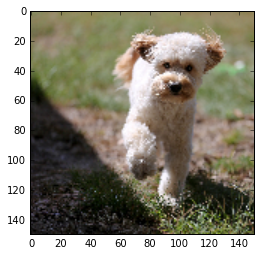

In [3]:
img_path = 'images/dog.jpg'

# We preprocess the image into a 4D tensor
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

Now that we've loaded an image to visualize the network with, we can create a Model that accepts inputs of image batches and returns outputs of all the layers of the original network.

"To do this, we will use the Keras class Model. A Model is instantiated using two arguments: an input tensor (or list of input tensors), and an output tensor (or list of output tensors). The resulting class is a Keras model, just like the Sequential models that you are familiar with, mapping the specified inputs to the specified outputs. What sets the  Model class apart is that it allows for models with multiple outputs, unlike Sequential. For more information about the Model class, see Chapter 7, Section 1." (Chollet)

In [67]:
from keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

Notice that this is not a traditional Keras model in that there are multiple outputs. Generally speaking, Keras supports an arbitrary number of inputs and outputs to a model, but we have used one-input, one-output models up to this point.

In [68]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


Using this multi-output model, we can visualize the activation of any arbitrary channel of any layer of the network. For example, here is a channel of the first layer that appears to function as a diagonal edge detector.

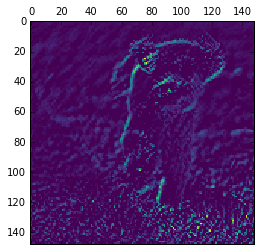

In [65]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 29], cmap='viridis')
plt.show()

This can be extended to visualize every channel of every layer in the network, which gives us eyes into the black box of the convolutional cats-and-dogs network. The following code (Chollet) plots every single channel side-by-side for each layer of the network.

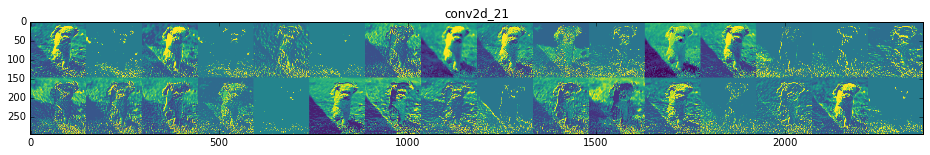

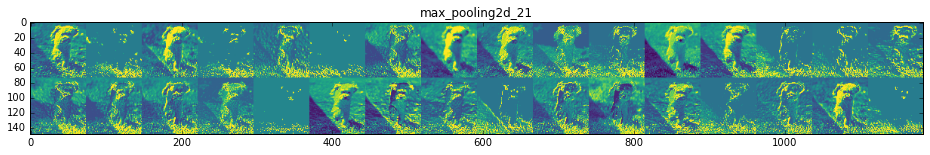

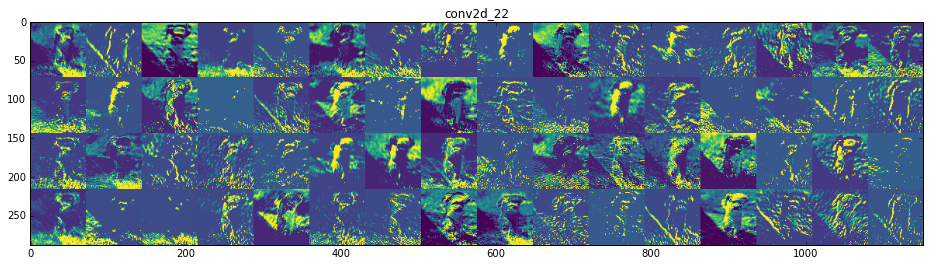

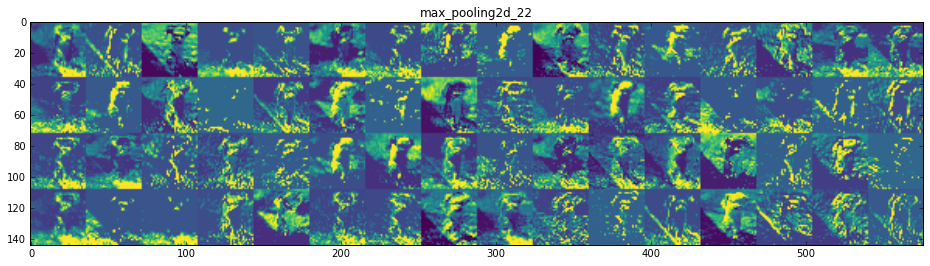

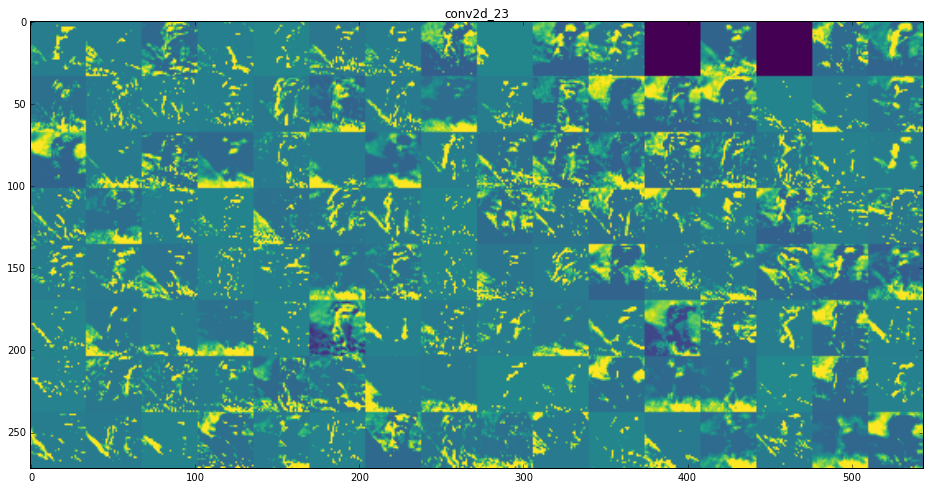

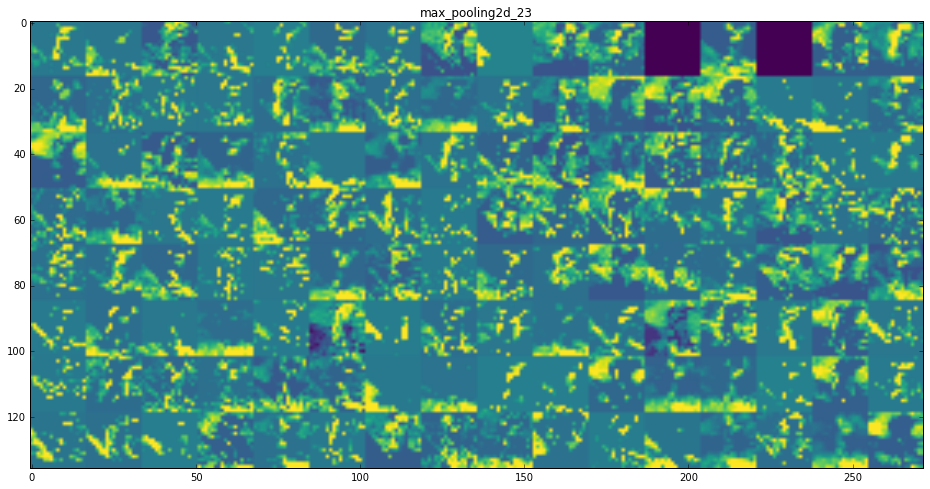

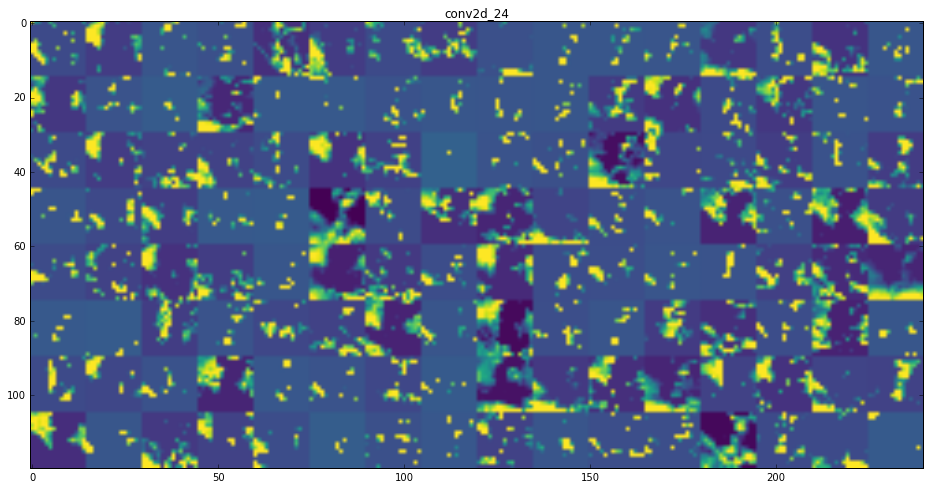

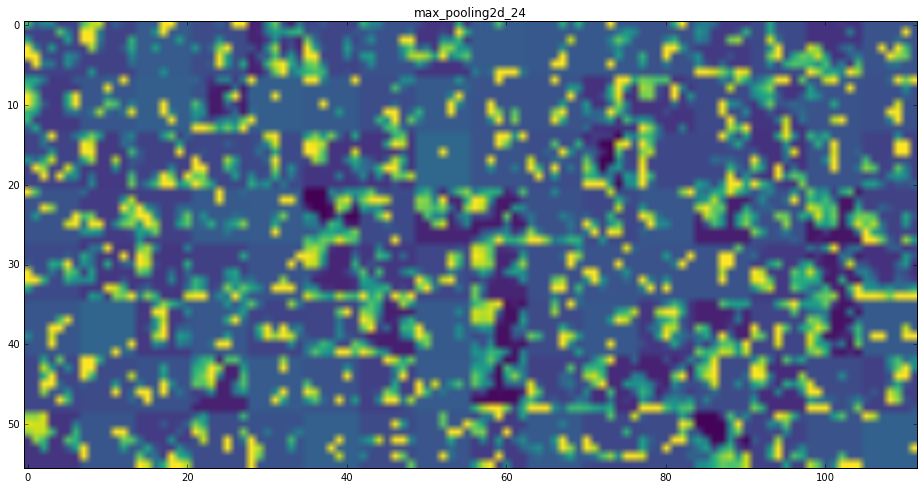

In [70]:
import keras

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

Notice that as we move downward through this figure, into deeper layers of the network, the activations retain less and less of the original input content. The channels serve primarily as edge detectors and the like, while later layers retain very little of the original form of the image. Moreover, in some later layers, there is no activation. For example, in max_pooling2d_23, there are two channels with no activation. This indicates that the pattern represented by that channel is not present in the source image.

It is important to identify that, as you move deeper into the network, the features that activate a given channel become more and more abstract. Chollet describes this behaviour by comparing a convolutional neural network to an **information distillation pipeline**, which iteratively transforms raw data such that irrelevant information is "filtered out and useful information is magnified."

I encourage you to try your own image of a dog or cat and examine the activations with that image. Spend some time looking at what all the activations look like. Can you identify any high-level abstract concepts that are identified by later-level layers? Perhaps dog ears or cat eyes?

### Visualizing Convolutional Filters

We can also perform the inverse operation, in some sense, by synthesizing images to maximize the response from a specific filter. This allows us to visualize the pattern that a given channel responds to. This can be performed with gradient ascent, a process wherein you perform gradient descent on the input image to a network, starting with a blank image. The final result image, in an optimal gradient ascent, is maximally activating of the chosen filter.

Chollet performs this with the following code, which utliized stochastic gradient descent to synthesize an image which

### Classification Activation Heatmaps